# Character RNN Model

In [533]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from typing import List

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Read data

In [536]:
# script_df = pd.read_csv('data/seinfeld_scripts.csv')

# script_subset_df = script_df[(script_df['season'] == 7) & (script_df['episode'].isin([1, 2, 3, 4, 5, 6]))]

# subtext = '\n\n'.join(script_subset_df['character'] + ': ' + script_subset_df['dialogue'].tolist())

# with open('data/seinfeld_scripts_s7_1_2_3_4_5_6.txt', "w") as text_file:
#     text_file.write(subtext)

In [470]:
# Load the dataset
text = open("./data/seinfeld_scripts_s7_1_2_3.txt").read().lower()
total_chars = len(text)
print(f"Length of text: {total_chars} characters")

Length of text: 54613 characters


In [471]:
# Take a look at the first 250 characters in text
print(text[:750])

george: well, you got no place to go. i'll tell you what your problem is you brought your queen out too fast. what do you think? she's one of these feminists looking to get out of the house? no, the queen is old fashioned.. likes to stay home. cook. take care of her man. make sure he feels good.

liz: checkmate.

george: i don't think we should see each other any more.

elaine: shut up! shut up! you stupid mutt.

jerry: and you broke up with her 'cuz she beat you at chess? that's pretty sick.

george: i don't see how i could perform sexually in a situation after something like that. i was completely emasculated. anyway, it's not the only reason.

jerry: yeah, what else?

george: all right. you wanna know what one of her favorite expressions is? happy, pappy?

jerry: happy, pappy? what does that mean?

george: like if she wants to know if i'm pleased with something, she'll say, `happy, pappy?`

jerry: oh, you're `pappy`.

george: i'm `pappy`.

jerry: oh, i get it. why don't you just say

## Building the Character Vocabulary

In [472]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(char_level=True)

# Generate the word index dictionary
tokenizer.fit_on_texts([text])

# +1 for the padding token
distinct_chars = len(tokenizer.word_index) + 1

print(f"char index dictionary: {tokenizer.word_index}")
print(f"distinct chars: {distinct_chars}")

char index dictionary: {' ': 1, 'e': 2, 'o': 3, 't': 4, 'a': 5, 'r': 6, 'i': 7, 'n': 8, 'h': 9, 's': 10, '\n': 11, 'l': 12, 'y': 13, 'u': 14, 'g': 15, '.': 16, 'd': 17, 'm': 18, 'w': 19, ':': 20, 'c': 21, 'k': 22, "'": 23, ',': 24, 'b': 25, 'f': 26, 'p': 27, 'j': 28, '?': 29, 'v': 30, '!': 31, 'x': 32, '`': 33, '-': 34, 'z': 35, '0': 36, 'q': 37, '5': 38, '2': 39, '1': 40, '7': 41, '4': 42, '3': 43, '[': 44, ']': 45, ';': 46, '9': 47, '8': 48, '$': 49}
distinct chars: 50


## Preprocessing the Dataset

```
INPUT                                        LABEL
------------------------------------------------------------------------------
what's the deal with airplane pea    --->    hat's the deal with airplane pean 
hat's the deal with airplane pean    --->    at's the deal with airplane peanu
at's the deal with airplane peanu    --->    t's the deal with airplane peanut
t's the deal with airplane peanut    --->    's the deal with airplane peanuts
```

In [473]:
def encode(text: str) -> List :
    return tokenizer.texts_to_sequences([text])[0]

encoded_text = encode(text)

In [534]:
# Take a look at the first 250 characters in tokens
sample_encoded_text = encoded_text[:750]
print(sample_encoded_text)

[15, 2, 3, 6, 15, 2, 20, 1, 19, 2, 12, 12, 24, 1, 13, 3, 14, 1, 15, 3, 4, 1, 8, 3, 1, 27, 12, 5, 21, 2, 1, 4, 3, 1, 15, 3, 16, 1, 7, 23, 12, 12, 1, 4, 2, 12, 12, 1, 13, 3, 14, 1, 19, 9, 5, 4, 1, 13, 3, 14, 6, 1, 27, 6, 3, 25, 12, 2, 18, 1, 7, 10, 1, 13, 3, 14, 1, 25, 6, 3, 14, 15, 9, 4, 1, 13, 3, 14, 6, 1, 37, 14, 2, 2, 8, 1, 3, 14, 4, 1, 4, 3, 3, 1, 26, 5, 10, 4, 16, 1, 19, 9, 5, 4, 1, 17, 3, 1, 13, 3, 14, 1, 4, 9, 7, 8, 22, 29, 1, 10, 9, 2, 23, 10, 1, 3, 8, 2, 1, 3, 26, 1, 4, 9, 2, 10, 2, 1, 26, 2, 18, 7, 8, 7, 10, 4, 10, 1, 12, 3, 3, 22, 7, 8, 15, 1, 4, 3, 1, 15, 2, 4, 1, 3, 14, 4, 1, 3, 26, 1, 4, 9, 2, 1, 9, 3, 14, 10, 2, 29, 1, 8, 3, 24, 1, 4, 9, 2, 1, 37, 14, 2, 2, 8, 1, 7, 10, 1, 3, 12, 17, 1, 26, 5, 10, 9, 7, 3, 8, 2, 17, 16, 16, 1, 12, 7, 22, 2, 10, 1, 4, 3, 1, 10, 4, 5, 13, 1, 9, 3, 18, 2, 16, 1, 21, 3, 3, 22, 16, 1, 4, 5, 22, 2, 1, 21, 5, 6, 2, 1, 3, 26, 1, 9, 2, 6, 1, 18, 5, 8, 16, 1, 18, 5, 22, 2, 1, 10, 14, 6, 2, 1, 9, 2, 1, 26, 2, 2, 12, 10, 1, 15, 3, 3, 17, 16, 11, 11, 

In [475]:
# when char_level = True, sequences_to_texts puts spaces between characters during decoding
def decode(
    tokenizer: tf.keras.preprocessing.text.Tokenizer, 
    tokenized_text: List
) -> str:
    return ''.join([tokenizer.sequences_to_texts([[token]])[0] for token in tokenized_text])

In [535]:
sample_decoded_text = decode(tokenizer, sample_encoded_text[0:750])
print(sample_decoded_text)

george: well, you got no place to go. i'll tell you what your problem is you brought your queen out too fast. what do you think? she's one of these feminists looking to get out of the house? no, the queen is old fashioned.. likes to stay home. cook. take care of her man. make sure he feels good.

liz: checkmate.

george: i don't think we should see each other any more.

elaine: shut up! shut up! you stupid mutt.

jerry: and you broke up with her 'cuz she beat you at chess? that's pretty sick.

george: i don't see how i could perform sexually in a situation after something like that. i was completely emasculated. anyway, it's not the only reason.

jerry: yeah, what else?

george: all right. you wanna know what one of her favorite expressions


In [477]:
seq_length = 100
xs = []
ys = []
for i in range(0, total_chars):
    xs.append(
        pad_sequences([encoded_text[i:seq_length + i]], maxlen=seq_length, padding="pre")[0]
    )
    ys.append(
        pad_sequences([encoded_text[1 + i:seq_length + 1 + i]], maxlen=seq_length, padding="pre")[0]
    )
    
xs = np.array(xs)
ys = np.array(ys)

In [478]:
for i in range(2):
    print(f'xs[{i}]: {xs[i]}')
    print(f'decoded xs[{i}]: {decode(tokenizer, xs[i])}')
    print()
    print(f'ys[{i}]: {ys[i]}')
    print(f'decoded ys[{i}]: {decode(tokenizer, ys[i])}')
    print('\n================================================\n')

xs[0]: [15  2  3  6 15  2 20  1 19  2 12 12 24  1 13  3 14  1 15  3  4  1  8  3
  1 27 12  5 21  2  1  4  3  1 15  3 16  1  7 23 12 12  1  4  2 12 12  1
 13  3 14  1 19  9  5  4  1 13  3 14  6  1 27  6  3 25 12  2 18  1  7 10
  1 13  3 14  1 25  6  3 14 15  9  4  1 13  3 14  6  1 37 14  2  2  8  1
  3 14  4  1]
decoded xs[0]: george: well, you got no place to go. i'll tell you what your problem is you brought your queen out 

ys[0]: [ 2  3  6 15  2 20  1 19  2 12 12 24  1 13  3 14  1 15  3  4  1  8  3  1
 27 12  5 21  2  1  4  3  1 15  3 16  1  7 23 12 12  1  4  2 12 12  1 13
  3 14  1 19  9  5  4  1 13  3 14  6  1 27  6  3 25 12  2 18  1  7 10  1
 13  3 14  1 25  6  3 14 15  9  4  1 13  3 14  6  1 37 14  2  2  8  1  3
 14  4  1  4]
decoded ys[0]: eorge: well, you got no place to go. i'll tell you what your problem is you brought your queen out t


xs[1]: [ 2  3  6 15  2 20  1 19  2 12 12 24  1 13  3 14  1 15  3  4  1  8  3  1
 27 12  5 21  2  1  4  3  1 15  3 16  1  7 23 12 12  1  4  

## Building the model

In [504]:
embedding_dim = 128
lstm_units = 256
dense_dim = 128
learning_rate = 0.01

model = Sequential(
    [
        Embedding(distinct_chars, embedding_dim, input_length=seq_length),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Bidirectional(LSTM(int(lstm_units / 2), return_sequences=True)),
        Dense(dense_dim),
        Dense(
            distinct_chars, 
        ),  # not using softmax activation here, using the logits instead
    ]
)

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
)

# Print the model summary
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 100, 128)          6400      
                                                                 
 bidirectional_71 (Bidirecti  (None, 100, 512)         788480    
 onal)                                                           
                                                                 
 bidirectional_72 (Bidirecti  (None, 100, 256)         656384    
 onal)                                                           
                                                                 
 dense_57 (Dense)            (None, 100, 128)          32896     
                                                                 
 dense_58 (Dense)            (None, 100, 50)           6450      
                                                                 
Total params: 1,490,610
Trainable params: 1,490,610
N

## Training the model

In [505]:
epochs = 15
batch_size = 256

# Train the model
history = model.fit(xs, ys, epochs=epochs, batch_size=batch_size)

Epoch 1/15


2022-11-02 23:08:40.962391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:42.143936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:42.166470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:45.023353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:45.131079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:47.046187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-02 23:08:47.082158: I tensorflow/core/grappler/optimizers/cust

214/214 [==============================] - 96s 400ms/step - loss: 1.6233
Epoch 2/15
214/214 [==============================] - 91s 424ms/step - loss: 0.0349
Epoch 3/15
214/214 [==============================] - 89s 414ms/step - loss: 0.0246
Epoch 4/15
214/214 [==============================] - 86s 396ms/step - loss: 0.0223
Epoch 5/15
214/214 [==============================] - 82s 379ms/step - loss: 0.0209
Epoch 6/15
214/214 [==============================] - 82s 381ms/step - loss: 0.0197
Epoch 7/15
214/214 [==============================] - 84s 392ms/step - loss: 0.0190
Epoch 8/15
214/214 [==============================] - 86s 403ms/step - loss: 0.0180
Epoch 9/15
214/214 [==============================] - 88s 410ms/step - loss: 0.0175
Epoch 10/15
214/214 [==============================] - 89s 417ms/step - loss: 0.0171
Epoch 11/15
214/214 [==============================] - 108s 499ms/step - loss: 0.0165
Epoch 12/15
214/214 [==============================] - 85s 391ms/step - loss: 0.0160

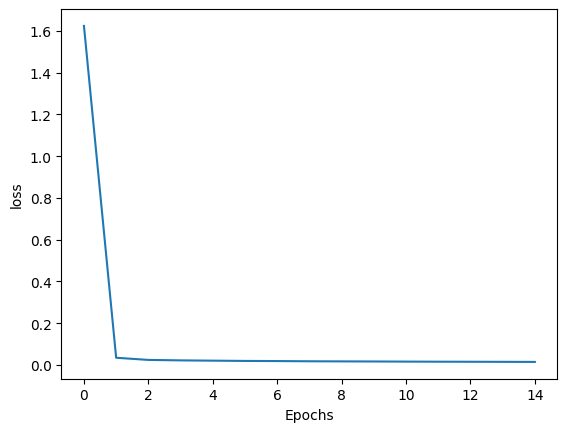

In [506]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

plot_graphs(history, "loss")

## Generating new dialogue

In [532]:
characters_to_predict = 1500
seed_text = decode(tokenizer, xs[0, :])

make_random = True

print(f'SEED TEXT:')
print('=================================================')
print(seed_text)
print('=================================================\n')

for i in range(characters_to_predict):
    encoded_seed_text = encode(seed_text)
    padded_seed_text = np.expand_dims(
        pad_sequences([encoded_seed_text], maxlen=seq_length, padding="pre")[0], 0
    )
    pred = model.predict(padded_seed_text, verbose=0)[0]
    
    # get the last set of probabilities for the character prediction
    preds_for_last_char = pred[-1]
    
    if make_random:
        # Pick a token from a multinomial distribution defined by the output logit layer
        token_draw = tf.random.categorical([preds_for_last_char], 1).numpy()[0][0]
    else:
        # Get the most likely token as the character prediction
        token_draw = np.argmax(preds_for_last_char)
    
    predicted_text = decode(tokenizer, [token_draw])
    seed_text += predicted_text

print(f'PREDICTED TEXT:')
print('=================================================')
print(seed_text)
print('=================================================')

SEED TEXT:
george: well, you got no place to go. i'll tell you what your problem is you brought your queen out 

PREDICTED TEXT:
george: well, you got no place to go. i'll tell you what your problem is you brought your queen out shade to fee all fried lety fet how know, roal.

elaine: come uronas.

george: well you. what's my fing the reaideay with. do know, wo! af telrase.

jerry: no you're would to secidy vicair?

jerry: the was got fined`ersatities! frienmany.

kramer: who vered something like. gonna sofne.

kramer: oh, yeah, well, know do isticem?

jerry: stay.

krame: it's condeytle, lounan confere are le -'s wituse laste you teal have wountelg in as to do: me, the chiy but say. i you sither?

jerry: the, we're use it... come kay... my's may make we'le are favailath to you reale, the beach, beol to filigh is to the looy anytap syfro makramergled sonstele anything more want cinds. cor rouse in$ goind to croubbene, of everys.

c'ge: any i'm know, it good i'd ricd.  torting? exifewe 